# Baseball Data: a thorough analysis 
#### A data set containing complete batting and pitching statistics from 1871 to 2014, plus fielding statistics, standings, team stats, managerial records, post-season data, and more. 

#### the data is available at: http://www.seanlahman.com/baseball-archive/statistics/

### Focus of our analysis
#### Our analysis will focus on players salaries:
- What is the salary evolution?
- Were different teams awarded different salaries?
    - were the difference justified?
- Were the players with the best statistics awarded the best salaries?
- Did the college attended influence salary of players?

### Packages needed

In [1]:
# Import General Packages
import numpy as np
import pandas as pd

# Import plotting/graphics packages
import matplotlib.pyplot as plt
import seaborn as sns 

# Graphics inline 
%matplotlib inline

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

### Importing the datasets of interest 

Main tables:
- MASTER - Player names, DOB, and biographical info
- Batting - batting statistics
- Pitching - pitching statistics
- Fielding - fielding statistics


Supplemented by theses tables 
- Teams - yearly stats and standings 
- Salaries - player salary data
- AwardsPlayers - awards won by players
- AwardsSharePlayers - award voting for player awards
- Schools - list of colleges that players attended
- CollegePlaying - list of players and the colleges they attended

In [2]:
master = pd.read_csv('baseballdatabank-2017.1/core/Master.csv')
batting = pd.read_csv('baseballdatabank-2017.1/core/Batting.csv')
pitching = pd.read_csv('baseballdatabank-2017.1/core/Pitching.csv')
fielding = pd.read_csv('baseballdatabank-2017.1/core/Fielding.csv')
teams = pd.read_csv('baseballdatabank-2017.1/core/Teams.csv')
salaries = pd.read_csv('baseballdatabank-2017.1/core/Salaries.csv')
awardPlayers = pd.read_csv('baseballdatabank-2017.1/core/AwardsPlayers.csv')
awardsSharePlayers = pd.read_csv('baseballdatabank-2017.1/core/AwardsSharePlayers.csv')
appearances = pd.read_csv('baseballdatabank-2017.1/core/Appearances.csv')
schools = pd.read_csv('baseballdatabank-2017.1/core/Schools.csv')
collegePlaying = pd.read_csv('baseballdatabank-2017.1/core/CollegePlaying.csv')
managers = pd.read_csv('baseballdatabank-2017.1/core/Managers.csv')

### External Data ###
#### Consumer Price Index from: https://data.bls.gov/timeseries/
I assume that the data for salaries is not adjusted to inflation (since no information could be found in the documentation). Therefore, we are going to adjust our salary data to inflation.

In [3]:
cpi_data = pd.read_excel('cpi_usa_85_2016.xlsx', header=10, index_col=None)

In [4]:
cpi_data.tail()

,Year,Jan,Feb,Mar,Apr,May,Jun,Jul,Aug,Sep,Oct,Nov,Dec,HALF1,HALF2
27,2012,226.665,227.663,229.392,230.085,229.815,229.478,229.104,230.379,231.407,231.317,230.221,229.601,228.850,230.338
28,2013,230.280,232.166,232.773,232.531,232.945,233.504,233.596,233.877,234.149,233.546,233.069,233.049,232.366,233.548
29,2014,233.916,234.781,236.293,237.072,237.900,238.343,238.250,237.852,238.031,237.433,236.151,234.812,236.384,237.088
30,2015,233.707,234.722,236.119,236.599,237.805,238.638,238.654,238.316,237.945,237.838,237.336,236.525,236.265,237.769
31,2016,236.916,237.111,238.132,239.261,240.229,241.018,240.628,240.849,241.428,241.729,241.353,241.432,238.778,241.237


In [5]:
#Taking the average of HALF1 and HALF 2 to form a yearly CPI
yearly_cpi = pd.DataFrame({'Year': cpi_data.Year,'inflation':(cpi_data.HALF1+cpi_data.HALF2)/2}) 

In [6]:
yearly_cpi.tail()

,Year,inflation
27,2012,229.5940
28,2013,232.9570
29,2014,236.7360
30,2015,237.0170
31,2016,240.0075


### Let's adjust our data to inflation 

In [7]:
dict_inflation = dict(zip(yearly_cpi.Year, yearly_cpi.inflation));

In [8]:
salaries['CPI'] = salaries['yearID'].map(dict_inflation)

In [9]:
cpi_2016 = yearly_cpi[yearly_cpi['Year']==2016]['inflation'].values[0]

In [10]:
salaries.head()

,yearID,teamID,lgID,playerID,salary,CPI
0,1985,ATL,NL,barkele01,870000,107.55
1,1985,ATL,NL,bedrost01,550000,107.55
2,1985,ATL,NL,benedbr01,545000,107.55
3,1985,ATL,NL,campri01,633333,107.55
4,1985,ATL,NL,ceronri01,625000,107.55


In [11]:
salaries['salary_adj'] = (salaries['salary']/salaries['CPI'])*cpi_2016

In [12]:
mean_salary_pa_adj = salaries.groupby(['yearID']).mean()['salary_adj']
median_salary_pa_adj = salaries.groupby(['yearID']).median()['salary_adj']
max_salary_pa_adj = salaries.groupby(['yearID']).max()['salary_adj']
top_quartile_pa_adj1 = salaries.groupby\
                               ('yearID', group_keys=False).apply\
                               (lambda g: g[g.salary_adj>= g.salary_adj.quantile(0.75)]).reset_index(drop=True)
top_quartile_pa_adj = top_quartile_pa_adj1.groupby('yearID')['salary_adj'].mean()

# Salary data, graphical analysis

In [13]:
mean_salary_pa = salaries.groupby(['yearID']).mean()['salary']
median_salary_pa = salaries.groupby(['yearID']).median()['salary']
max_salary_pa = salaries.groupby(['yearID']).max()['salary']
top_quartile_pa1 = salaries.groupby\
                               ('yearID', group_keys=False).apply\
                               (lambda g: g[g.salary>= g.salary.quantile(0.75)]).reset_index(drop=True)
top_quartile_pa = top_quartile_pa1.groupby('yearID')['salary'].mean()

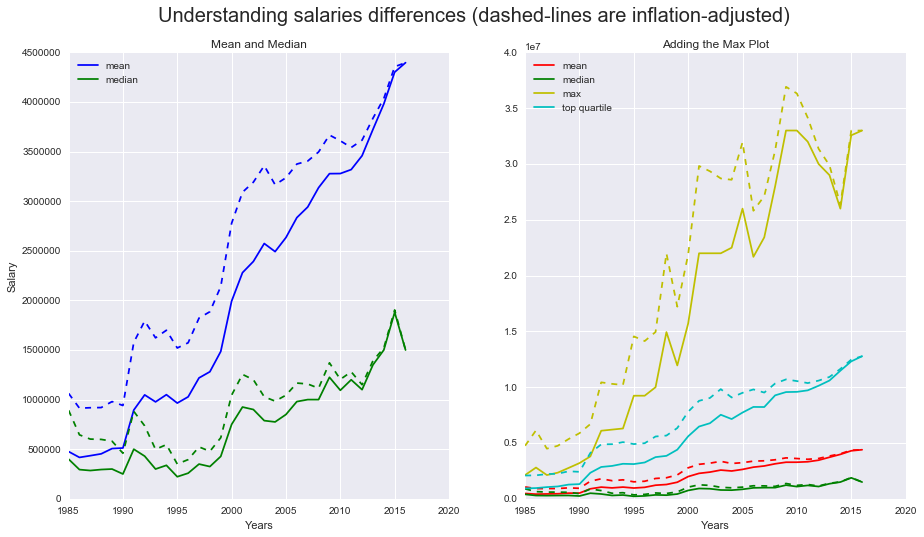

In [14]:
plt.figure(figsize=(15,8)) 
plt.suptitle('Understanding salaries differences (dashed-lines are inflation-adjusted)', fontsize=20)

plt.subplot(1, 2, 1)
plt.plot(mean_salary_pa, label='mean', c='blue')
plt.plot(mean_salary_pa_adj, ls='--',c='blue', label='')
plt.plot(median_salary_pa, label='median', c='green')
plt.plot(median_salary_pa_adj, label='', c='green', ls='--')

plt.legend(loc='upper left')
plt.xlabel('Years')
plt.ylabel('Salary')
plt.title('Mean and Median')

plt.subplot(1, 2, 2)
plt.plot(mean_salary_pa, label='mean', c='r')
plt.plot(mean_salary_pa_adj, label='', c='r', ls='--')
plt.plot(median_salary_pa, label='median', c='g')
plt.plot(median_salary_pa_adj, label='', c='g', ls='--')
plt.plot(max_salary_pa, label='max', c='y')
plt.plot(max_salary_pa_adj, label='', c='y', ls='--')
plt.plot(top_quartile_pa, label='top quartile', c='c')
plt.plot(top_quartile_pa_adj, label='', c='c', ls='--')
plt.legend(loc='upper left')
plt.xlabel('Years')
plt.title('Adding the Max Plot')

#### Histogram of salary

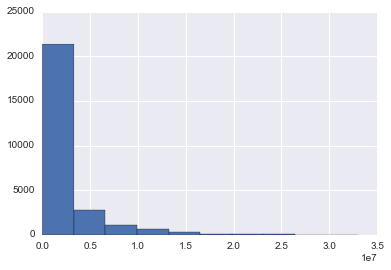

In [15]:
salaries.salary.hist()

#### First let's note that the data for the salaries is spanning from 1985 to 2016, unlike other datasets
- the inflation adjusted data does not change the trends so we will continue with the nominal data 
- the spread between mean an median increases at a fast rate 
- so we need a better understanding of the difference between average/median and maximum values. Since there are huge inequalities between players, what are the reasons:
    - skills?
    - college?
    - team?
    - but the first step would be to understand the origin of the maximum values

## Understanding the highest salaries

We shall look at the highest salaries per year and not overall because of salaries evolution, we would only get data in the latest years.

In [16]:
top_1pct_salaries_per_annum = salaries.groupby\
                               ('yearID', group_keys=False).apply\
                               (lambda g: g[g.salary>= g.salary.quantile(0.99)]).reset_index(drop=True)

In [17]:
top_1pct_salaries_per_annum.head()

,yearID,teamID,lgID,playerID,salary,CPI,salary_adj
0,1985,ATL,NL,murphda05,1625000,107.55,3.626334e+06
1,1985,NYA,AL,winfida01,1795704,107.55,4.007275e+06
2,1985,NYN,NL,cartega01,2028571,107.55,4.526939e+06
3,1985,NYN,NL,fostege01,1942857,107.55,4.335660e+06
4,1985,PHI,NL,schmimi01,2130300,107.55,4.753956e+06


### Who are these top paid players?

#### which teams do they belong to?

In [18]:
teams_top_salaries=[]
teams_no_top_salaries=[]

In [19]:
for team in salaries.teamID.unique():
    if team in top_1pct_salaries_per_annum.teamID.unique():
        teams_top_salaries.append(team)
    else:
        teams_no_top_salaries.append(team)

In [20]:
print "- Number of teams without top salaries (best 5% salaries) players: ",len(teams_no_top_salaries)
print "- Number of teams with top salaries players:", len(teams_top_salaries)

- Number of teams without top salaries (best 5% salaries) players:  12
- Number of teams with top salaries players: 34


In [21]:
print teams_top_salaries

['ATL', 'BAL', 'BOS', 'CAL', 'CHA', 'CHN', 'CIN', 'CLE', 'DET', 'HOU', 'KCA', 'LAN', 'MIN', 'ML4', 'NYA', 'NYN', 'OAK', 'PHI', 'PIT', 'SDN', 'SEA', 'SFN', 'SLN', 'TEX', 'TOR', 'COL', 'FLO', 'ANA', 'ARI', 'LAA', 'CHC', 'LAD', 'NYM', 'NYY']


In [22]:
# count the number of higly paid players per team over the whole period
top_1pct_salaries_per_annum.groupby('teamID')['playerID'].count().sort_values(ascending=False).head()

teamID
NYA    49
NYN    27
BOS    22
LAN    19
SFN    15
Name: playerID, dtype: int64

In [23]:
# count the number of higly paid players per team per year
top_1pct_salaries_per_annum.groupby(['teamID', 'yearID'])['playerID'].count().head()

teamID  yearID
ANA     2000      1
        2001      1
ARI     1999      1
        2000      1
        2001      1
Name: playerID, dtype: int64

##### Some team do indeed have more higly paid players 

### Why these teams have highly paid players? Do they win more on average?

#### Interesting dimensions to explore are:
- Rank: position in final standings
- W: Wins
- L: Losses
- DivWin: Division Winner (Y or N)
- WCWin: Wild Card Winner (Y or N)
- LgWin: League Champion(Y or N)
- WSWin: World Series Winner (Y or N)
- HR: Homeruns by batters
- SV: Saves
- E: Errors
- name: Team's full name

In [24]:
teams.head(2)

,yearID,lgID,teamID,franchID,divID,Rank,G,Ghome,W,L,DivWin,WCWin,LgWin,WSWin,R,AB,H,2B,3B,HR,BB,SO,SB,CS,HBP,SF,RA,ER,ERA,CG,SHO,SV,IPouts,HA,HRA,BBA,SOA,E,DP,FP,name,park,attendance,BPF,PPF,teamIDBR,teamIDlahman45,teamIDretro
0,1871,NaN,BS1,BNA,NaN,3,31,NaN,20,10,NaN,NaN,N,NaN,401,1372,426,70,37,3,60,19.0,73.0,NaN,NaN,NaN,303,109,3.55,22,1,3,828,367,2,42,23,225,NaN,0.838,Boston Red Stockings,South End Grounds I,NaN,103,98,BOS,BS1,BS1
1,1871,NaN,CH1,CNA,NaN,2,28,NaN,19,9,NaN,NaN,N,NaN,302,1196,323,52,21,10,60,22.0,69.0,NaN,NaN,NaN,241,77,2.76,25,0,1,753,308,6,28,22,218,NaN,0.829,Chicago White Stockings,Union Base-Ball Grounds,NaN,104,102,CHI,CH1,CH1


In [25]:
# Since we only have salaries data from 1985, we do not need the whole dataset so we slice the part of the dataframe
# we are interest into
teams_1985_2016 = teams[teams['yearID']>=1985]

In [26]:
teams_1985_2016.head(2)

,yearID,lgID,teamID,franchID,divID,Rank,G,Ghome,W,L,DivWin,WCWin,LgWin,WSWin,R,AB,H,2B,3B,HR,BB,SO,SB,CS,HBP,SF,RA,ER,ERA,CG,SHO,SV,IPouts,HA,HRA,BBA,SOA,E,DP,FP,name,park,attendance,BPF,PPF,teamIDBR,teamIDlahman45,teamIDretro
1917,1985,NL,ATL,ATL,W,5,162,81.0,66,96,N,NaN,N,N,632,5526,1359,213,28,126,553,849.0,72.0,52.0,NaN,NaN,781,678,4.19,9,9,29,4371,1512,134,642,776,159,197.0,0.976,Atlanta Braves,Atlanta-Fulton County Stadium,1350137.0,105,106,ATL,ATL,ATL
1918,1985,AL,BAL,BAL,E,4,161,81.0,83,78,N,NaN,N,N,818,5517,1451,234,22,214,604,908.0,69.0,43.0,NaN,NaN,764,694,4.38,32,6,33,4281,1480,160,568,793,115,168.0,0.980,Baltimore Orioles,Memorial Stadium,2132387.0,97,97,BAL,BAL,BAL


In [27]:
# create a new columns which maps whether the team has high payed players or not 

In [28]:
def add_column_bin_salaries(team):
    if team in teams_top_salaries:
        return 1
    elif team in teams_no_top_salaries:
        return 0
    else:
        return -1

In [29]:
#return a new column matching values from the function add_column_bin_salaries

teams_1985_2016['topSalary'] = teams_1985_2016['teamID'].apply(add_column_bin_salaries)

/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  app.launch_new_instance()


In [30]:
teams_1985_2016.tail(2)

,yearID,lgID,teamID,franchID,divID,Rank,G,Ghome,W,L,DivWin,WCWin,LgWin,WSWin,R,AB,H,2B,3B,HR,BB,SO,SB,CS,HBP,SF,RA,ER,ERA,CG,SHO,SV,IPouts,HA,HRA,BBA,SOA,E,DP,FP,name,park,attendance,BPF,PPF,teamIDBR,teamIDlahman45,teamIDretro,topSalary
2833,2016,AL,TOR,TOR,E,2,162,81.0,89,73,N,Y,N,N,759,5479,1358,276,18,221,632,1362.0,54.0,24.0,55.0,40.0,666,613,3.78,0,10,43,4378,1340,183,461,1314,88,144.0,0.986,Toronto Blue Jays,Rogers Centre,3392099.0,111,110,TOR,TOR,TOR,1
2834,2016,NL,WAS,WSN,E,1,162,81.0,95,67,Y,N,N,N,763,5490,1403,268,29,203,536,1252.0,121.0,39.0,64.0,63.0,612,570,3.51,1,12,46,4379,1272,155,468,1476,73,142.0,0.988,Washington Nationals,Nationals Park,2481938.0,100,98,WSN,MON,WAS,0


In [31]:
avg_wins_per_group = pd.DataFrame(teams_1985_2016.groupby(['yearID', 'topSalary'])['W'].mean()).reset_index()
avg_losses_per_group = pd.DataFrame(teams_1985_2016.groupby(['yearID', 'topSalary'])['L'].mean()).reset_index()

In [32]:
avg_losses_per_group.head()

,yearID,topSalary,L
0,1985,0,77.00
1,1985,1,80.96
2,1986,0,83.00
3,1986,1,80.76
4,1987,0,71.00


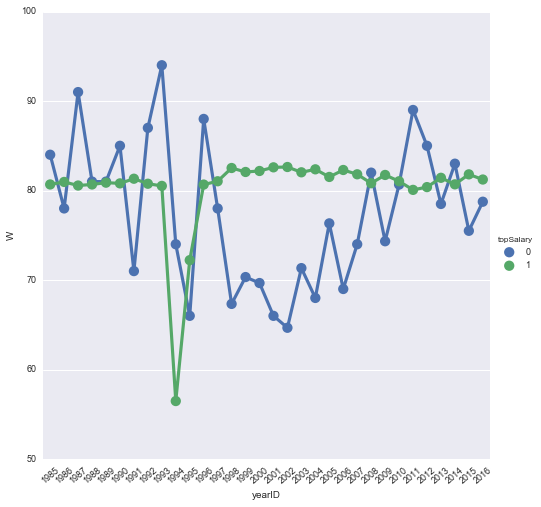

In [33]:
sns.set(font_scale=0.9)
f = sns.factorplot(x="yearID", y="W",data=avg_wins_per_group, hue='topSalary', size=7)
f.set_xticklabels(rotation=40)
#put a title, average wins with top and without top salaries

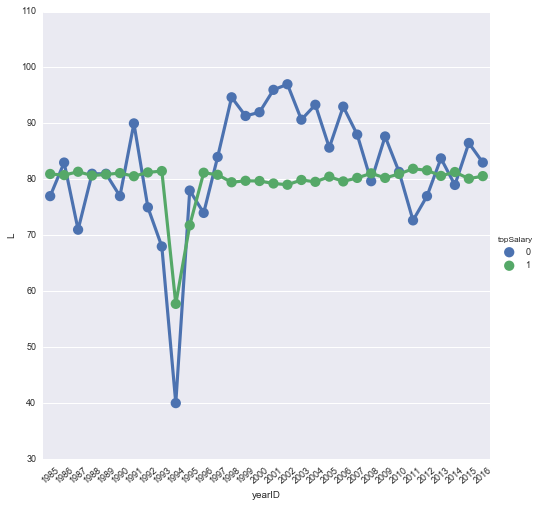

In [34]:
sns.set(font_scale=0.9)
f = sns.factorplot(x="yearID", y="L",data=avg_losses_per_group, hue='topSalary', size=7)
f.set_xticklabels(rotation=40)

- can see that something interesting happened in 1994:
    - actually when looking into it, there was a player strike that ended the season abruptly (http://www.usatoday.com/story/sports/mlb/2014/08/11/1994-mlb-strike/13912279/) 
- teams with top salary player(s) tend to have steady performances in terms of average wins and losses 
    - on average they win more
- teams without top salary player(s) have more volatile performances

#### - further it could be interesting to see if the players playing in teams with no top salaries moved to top salaries team the years where their teams performed well 

## Exploring the players attributes

###  Look at the most paid players (the top 1%) and looks into them, where they come from  and their statistics compared to average satistics so see if salaries are really justified.

In [35]:
top_1pct_salaries_per_annum.head()

,yearID,teamID,lgID,playerID,salary,CPI,salary_adj
0,1985,ATL,NL,murphda05,1625000,107.55,3.626334e+06
1,1985,NYA,AL,winfida01,1795704,107.55,4.007275e+06
2,1985,NYN,NL,cartega01,2028571,107.55,4.526939e+06
3,1985,NYN,NL,fostege01,1942857,107.55,4.335660e+06
4,1985,PHI,NL,schmimi01,2130300,107.55,4.753956e+06


In [36]:
print 'lenght batting dataset: ',len(batting)
print 'lenght pitching dataset: ', len(pitching)
print 'lenght fielding dataset: ', len(fielding)

lenght batting dataset:  102816
lenght pitching dataset:  44963
lenght fielding dataset:  136815


In [37]:
# so we need to check where our higly players are or if they are in several datasets we can create three columns to 
# check if player is battling, pitching or fielding 

In [38]:
# One player 'sabatc.01' is not in pitching, bating or fielding, where is he? is this an error? (we found that later
#but we moved it here to avoid rerunning the code)
import fnmatch
players = master.playerID.unique()
pattern = 'sabatc*01'
matching = fnmatch.filter(players, pattern)
print matching

['sabatcc01']


In [39]:
# So we need to replace this value in the salaries and top_1pct_salaries_per_annum dataframes <= to be done
salaries.replace('sabatc.01', 'sabatcc01', inplace=True)
top_1pct_salaries_per_annum.replace('sabatc.01', 'sabatcc01', inplace=True)

In [40]:
def pitcher(player):
    if player in pitching.playerID.unique():
        return 1
    else:
        return 0
def batter(player):
    if player in batting.playerID.unique():
        return 1
    else:
        return 0
def fielder(player):
    if player in fielding.playerID.unique():
        return 1
    else:
        return 0

In [41]:
top_1pct_salaries_per_annum['pitcher'] = top_1pct_salaries_per_annum['playerID'].apply(pitcher)
top_1pct_salaries_per_annum['batter'] = top_1pct_salaries_per_annum['playerID'].apply(batter)
top_1pct_salaries_per_annum['fielder'] = top_1pct_salaries_per_annum['playerID'].apply(fielder)

In [42]:
top_1pct_salaries_per_annum.head()

,yearID,teamID,lgID,playerID,salary,CPI,salary_adj,pitcher,batter,fielder
0,1985,ATL,NL,murphda05,1625000,107.55,3.626334e+06,0,1,1
1,1985,NYA,AL,winfida01,1795704,107.55,4.007275e+06,0,1,1
2,1985,NYN,NL,cartega01,2028571,107.55,4.526939e+06,0,1,1
3,1985,NYN,NL,fostege01,1942857,107.55,4.335660e+06,0,1,1
4,1985,PHI,NL,schmimi01,2130300,107.55,4.753956e+06,0,1,1


In [43]:
print top_1pct_salaries_per_annum['pitcher'].sum()
print top_1pct_salaries_per_annum['batter'].sum()
print top_1pct_salaries_per_annum['fielder'].sum()

85
290
290


#### So all the players are batters and fielders (hope that is how you say it), and only 84 are pitchers. Are they the highest earners?

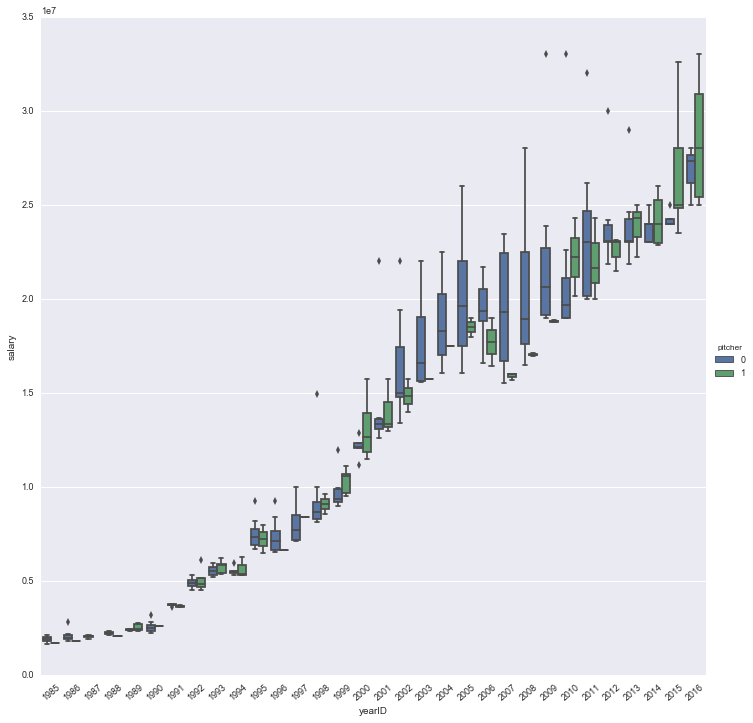

In [44]:
f = sns.factorplot(x='yearID', y='salary', kind='box', data=top_1pct_salaries_per_annum, hue='pitcher', size=10)
f.set_xticklabels(rotation=40)

#### Salary evolution betwen pitchers and batters for top_salaries
- there is an interesting evolution:
    - from 1985 1994 differences and spread between salaries seems small 
    - between 1994 and 2009: salaries spread ahs increased a lot, batter seem to be paid more in general
    - from 2010 onwards the spread reduces and pitcher become more paid in general than batters
- some outlier would need further exploration => 2009 to 2013 for batters there are some extreme outliers to checked out + 2001-2002 / 1995-1996 
    - we can notice that outliers or extreme values are only for batters (that were not pitchers), why?


### Who are these batters outliers in the previous graph? Were they exceptional players? errors?

In [45]:
# we need to extract the outliers per year, we should have 16-17
outliers =top_1pct_salaries_per_annum.groupby('yearID', group_keys=False)\
.apply(lambda g: g[g.salary>(g.salary.mean()+2.2*np.std(g.salary))]).reset_index(drop=True)

In [46]:
outliers.playerID.unique()

array(['fostege01', 'yountro01', 'bonilbo01', 'fieldce01', 'sheffga01',
       'belleal01', 'brownke01', 'rodrial01', 'kershcl01'], dtype=object)

In [47]:
outliers.groupby(['yearID','playerID']).sum().reset_index()

,yearID,playerID,salary,CPI,salary_adj,pitcher,batter,fielder
0,1986,fostege01,2800000,109.6000,6.131578e+06,0,1,1
1,1990,yountro01,3200000,130.6500,5.878485e+06,0,1,1
2,1992,bonilbo01,6100000,140.3000,1.043511e+07,1,1,1
3,1994,bonilbo01,6300000,148.2500,1.019931e+07,1,1,1
4,1995,fieldce01,9237500,152.3500,1.455247e+07,0,1,1
5,1996,fieldce01,9237500,156.8500,1.413497e+07,0,1,1
6,1998,sheffga01,14936667,163.0000,2.199333e+07,0,1,1
7,1999,belleal01,11949794,166.6000,1.721513e+07,0,1,1
8,2000,brownke01,15714286,172.2000,2.190213e+07,1,1,1
9,2001,rodrial01,22000000,177.0500,2.982302e+07,0,1,1


### actually we only have 9 players that are "outliers" in terms of salary, we will explore their performances later and compare them to top_earners and the general population

In [48]:
master[master['playerID']=='rodrial01']

,playerID,birthYear,birthMonth,birthDay,birthCountry,birthState,birthCity,deathYear,deathMonth,deathDay,deathCountry,deathState,deathCity,nameFirst,nameLast,nameGiven,weight,height,bats,throws,debut,finalGame,retroID,bbrefID
14668,rodrial01,1975.0,7.0,27.0,USA,NY,New York,NaN,NaN,NaN,NaN,NaN,NaN,Alex,Rodriguez,Alexander Enmanuel,230.0,75.0,R,R,1994-07-08,2016-08-12,rodra001,rodrial01


### Looking at players stats: Were the players with the best statistics awarded the best salaries?

#### let's look at the general population and see who were the actual best players

In [49]:
#step 1: segment the data from 1985 from all the statistics dataset to be able to compare it to our salaries
batting_1985 = batting[batting['yearID']>=1985]
pitching_1985 = pitching[pitching['yearID']>=1985]
fielding_1985 = fielding[fielding['yearID']>=1985]

### Exploring batting statistics

In [50]:
batting_1985.head()

,playerID,yearID,stint,teamID,lgID,G,AB,R,H,2B,3B,HR,RBI,SB,CS,BB,SO,IBB,HBP,SH,SF,GIDP
62239,aasedo01,1985,1,BAL,AL,54,0,0,0,0,0,0,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0,0.0,0.0
62240,abregjo01,1985,1,CHN,NL,6,9,0,0,0,0,0,1.0,0.0,0.0,0,2.0,0.0,0.0,0.0,0.0,0.0
62241,ackerji01,1985,1,TOR,AL,61,0,0,0,0,0,0,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0,0.0,0.0
62242,adamsri02,1985,1,SFN,NL,54,121,12,23,3,1,2,10.0,1.0,1.0,5,23.0,3.0,1.0,3.0,0.0,2.0
62243,agostju01,1985,1,CHA,AL,54,0,0,0,0,0,0,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0,0.0,0.0


#### Which key performance metrics shall we select?
- Home runs (HR)
- Runs Batted In (RBI)
- Hits (H)
- Runs (R)
- Intentional Walk (IBB)
- Doubles (2B)
- Triples (3B)
- Strikeouts (SO)
- Games (G)

In [51]:
# We need to add a column to separate between general population, top paid, outliers

In [52]:
def salary_status(player):
    if player in top_1pct_salaries_per_annum.playerID.unique():
        return 'top salary'
    else:
        return 'regular'

In [53]:
batting_1985['salary_status'] = batting_1985['playerID'].apply(salary_status)

/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':


In [54]:
# Now we want to plot the key performances by group
mean_battling_stats_per_year = batting_1985.groupby(['yearID', 'salary_status']).mean().reset_index()

In [89]:
indicators = ['HR', 'RBI', 'H', 'R', 'IBB', '2B', '3B', 'SO', 'G']

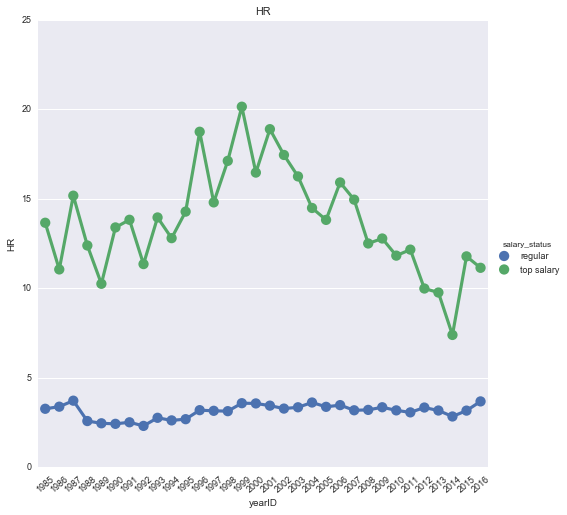

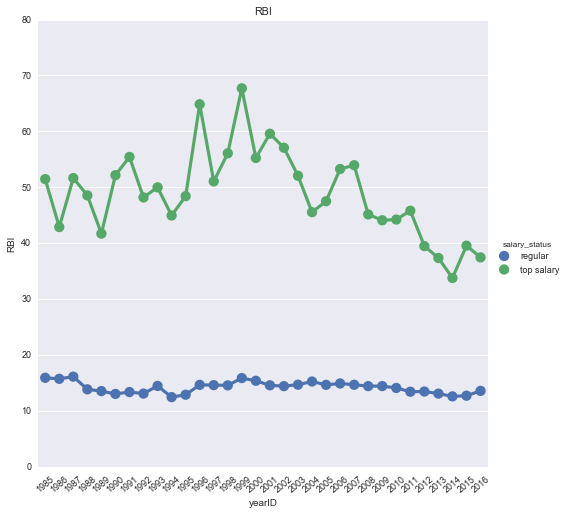

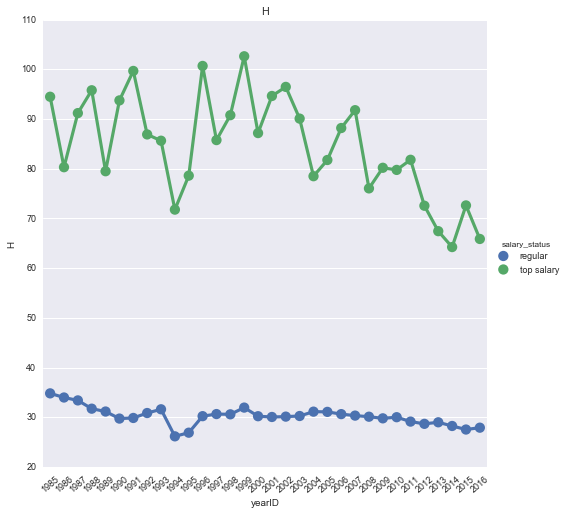

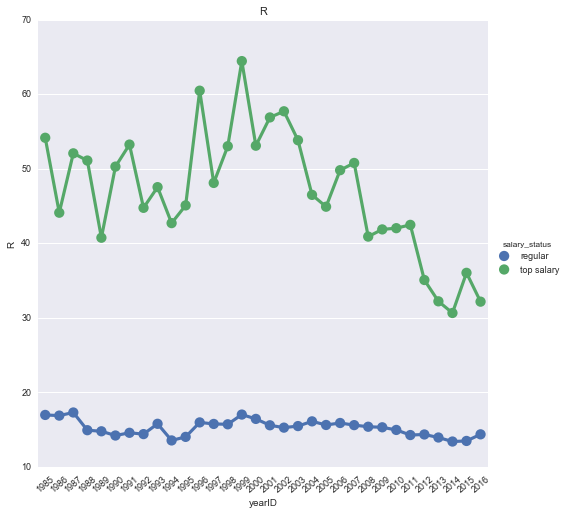

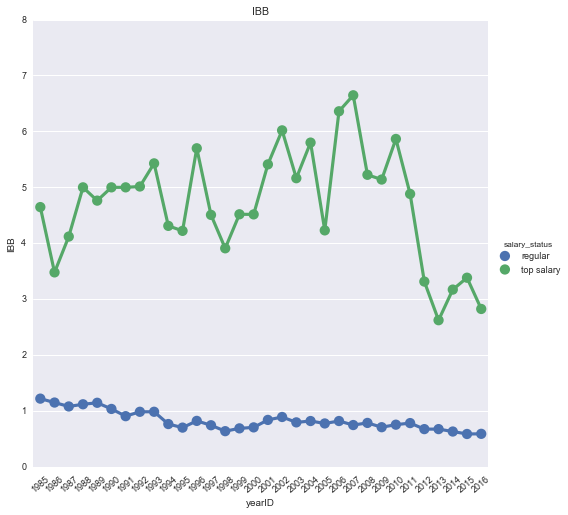

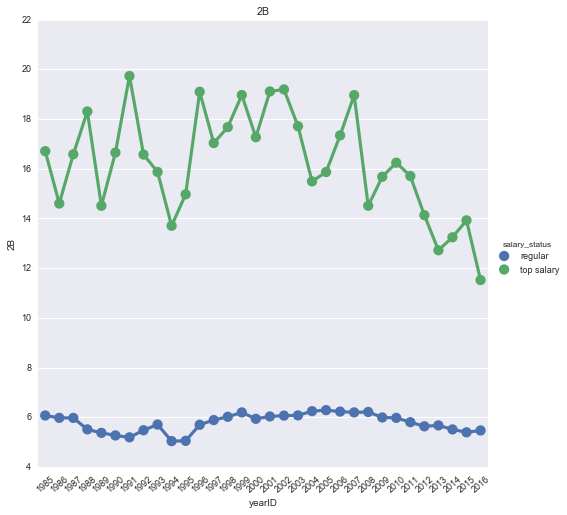

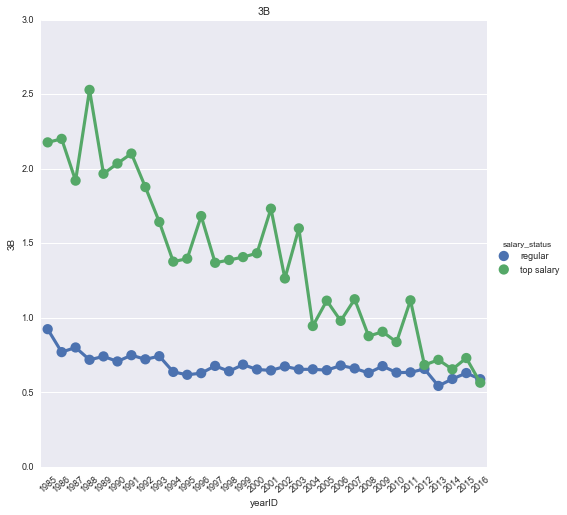

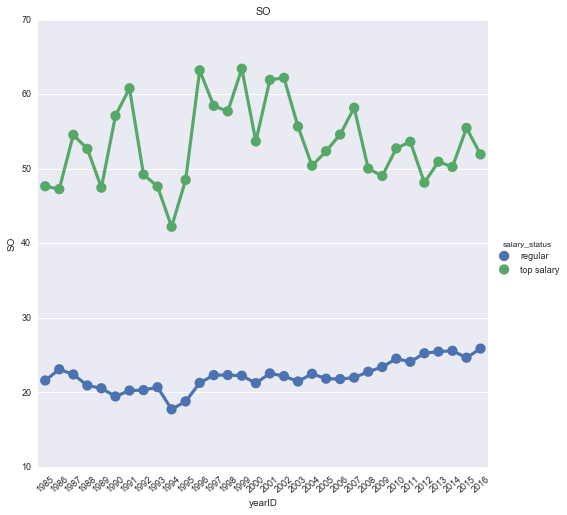

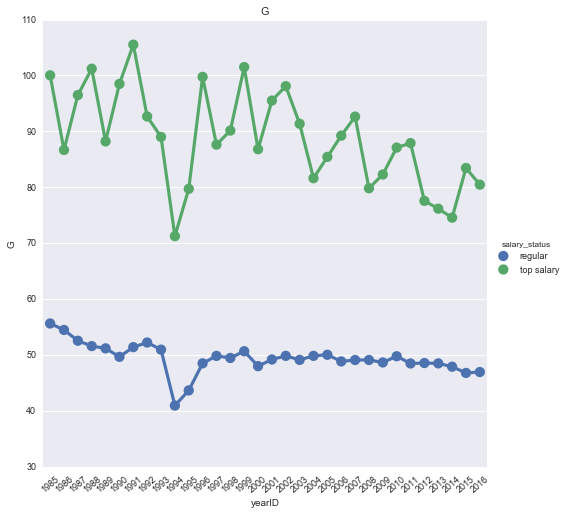

In [90]:
for stat in indicators:
    f = sns.factorplot(x='yearID', y=stat, hue='salary_status', data=mean_battling_stats_per_year, size=7)
    f.set_xticklabels(rotation=40)
    sns.plt.title(stat)


### Observations from the aboves graphs:
- regular paid players have, on average, more stable performances 
- beside Strikes Out, all key performances have experience a downward trend for top paid players 
- for triples, the average performances are the same for higly paid and normal players since 2012
- Therefore there must be other reasons for the tremendous increase in salary players since 1985.
- I have not done the pitching data ?!? or Fielding data ?!?

### Exploring Pitching statistics

In [102]:
pitching_1985.head()

,playerID,yearID,stint,teamID,lgID,W,L,G,GS,CG,SHO,SV,IPouts,H,ER,HR,BB,SO,BAOpp,ERA,IBB,WP,HBP,BK,BFP,GF,R,SH,SF,GIDP
24980,aasedo01,1985,1,BAL,AL,10,6,54,0,0,0,14,264,83,37,6,35,67,0.25,3.78,7.0,0.0,1.0,1,366.0,43.0,44,NaN,NaN,NaN
24981,abregjo01,1985,1,CHN,NL,1,1,6,5,0,0,0,72,32,17,3,12,13,0.35,6.38,1.0,0.0,0.0,0,109.0,0.0,18,NaN,NaN,NaN
24982,ackerji01,1985,1,TOR,AL,7,2,61,0,0,0,10,259,86,31,7,43,42,0.26,3.23,1.0,2.0,3.0,0,370.0,26.0,35,NaN,NaN,NaN
24983,agostju01,1985,1,CHA,AL,4,3,54,0,0,0,1,181,45,24,3,23,39,0.21,3.58,1.0,0.0,3.0,0,246.0,21.0,27,NaN,NaN,NaN
24984,aguilri01,1985,1,NYN,NL,10,7,21,19,2,0,0,367,118,44,8,37,74,0.25,3.24,2.0,5.0,2.0,2,507.0,1.0,49,NaN,NaN,NaN


#### Which key performance measures?
- W: Wins
- L: Losses
- G: Games
- CG: Complete Games 
- SHO: Shutouts
- SV: Saves
- IPOuts: Outs Pitched (innings pitched x 3) // in the table the label is IPouts (error documentation)
- H: Hits
- ER: Earned Runs
- HR: Homeruns
- SO: Strikeouts

In [105]:
pitching_1985['salary_status'] = pitching_1985['playerID'].apply(salary_status)

/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':


In [106]:
mean_pitching_stats_per_year = pitching_1985.groupby(['yearID', 'salary_status']).mean().reset_index()

In [111]:
performances_pitching = ['W', 'L', 'G', 'CG', 'SHO', 'SV', 'IPouts', 'H', 'ER', 'HR', 'SO']

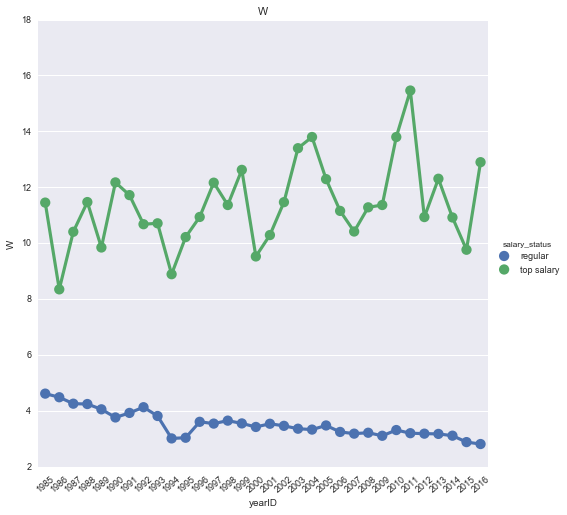

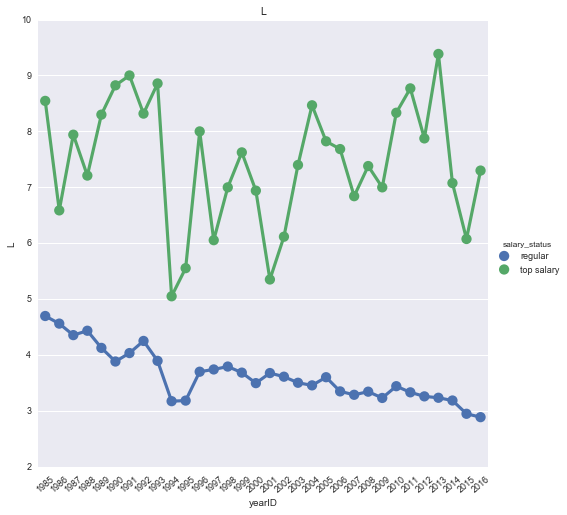

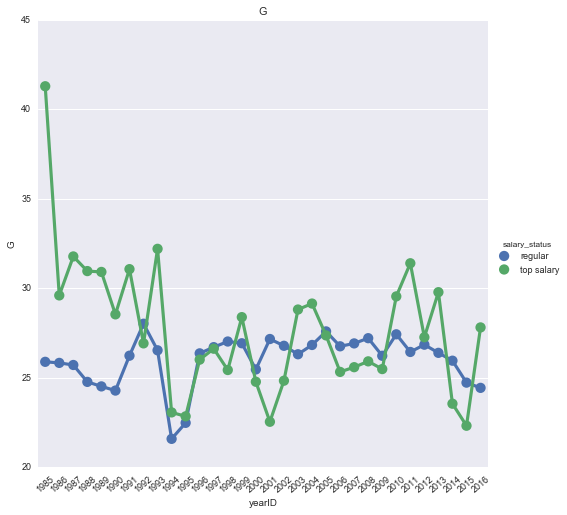

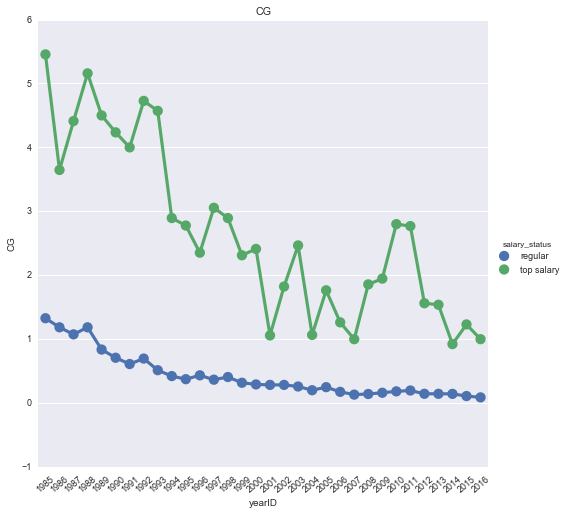

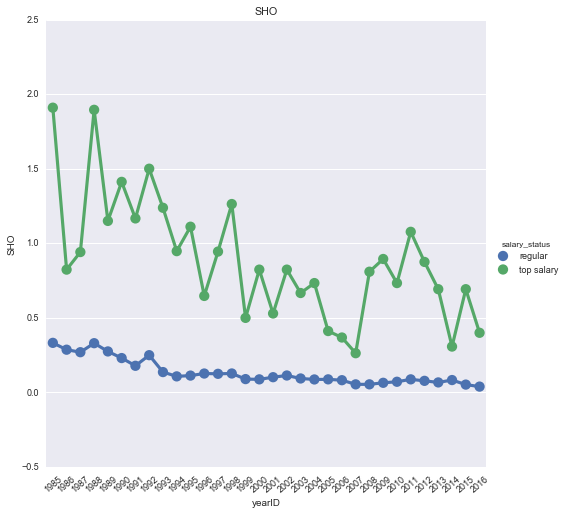

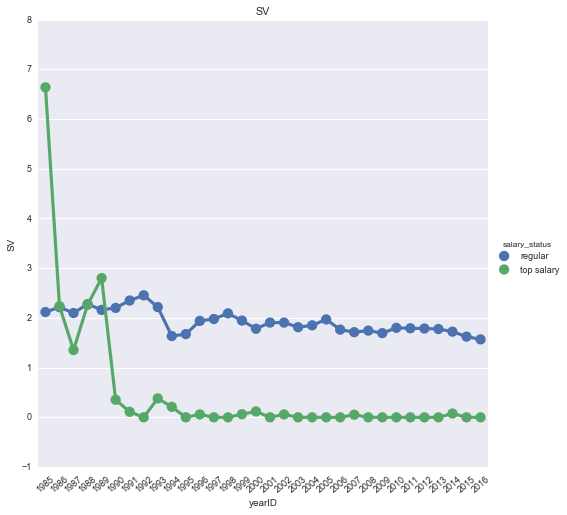

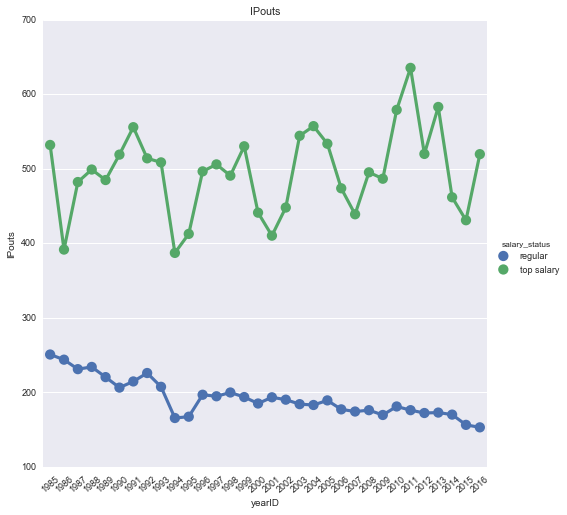

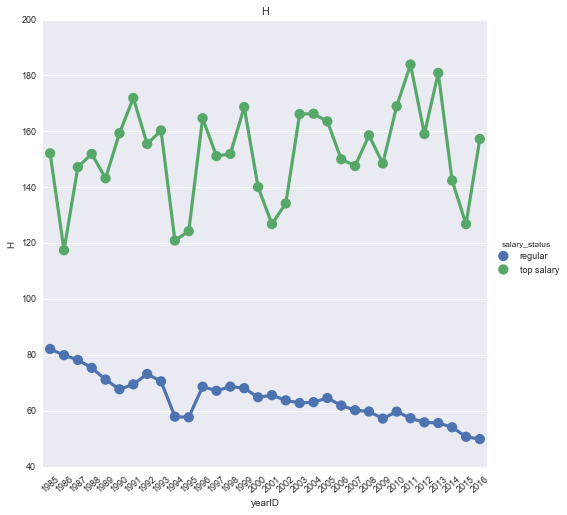

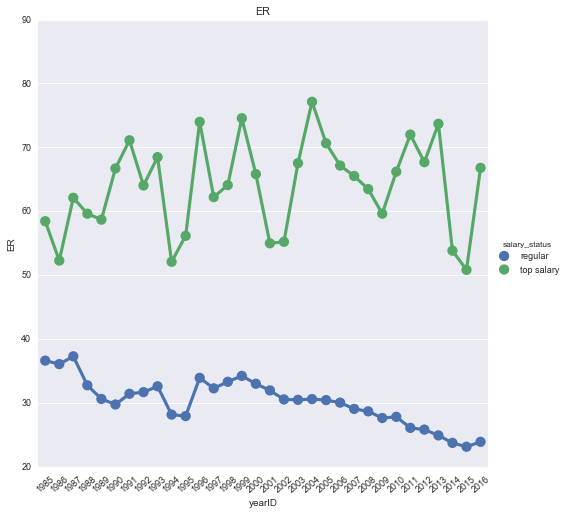

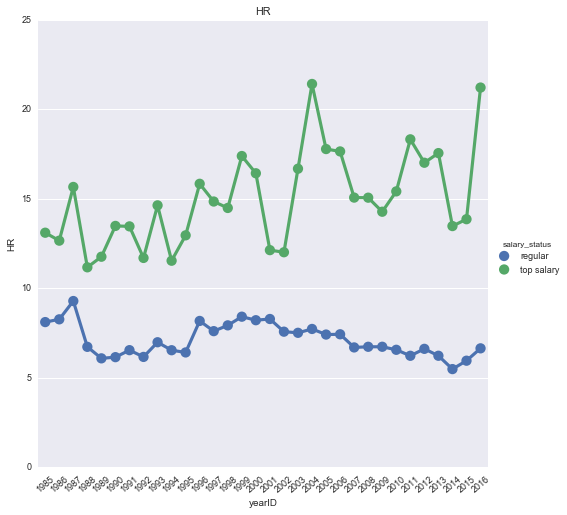

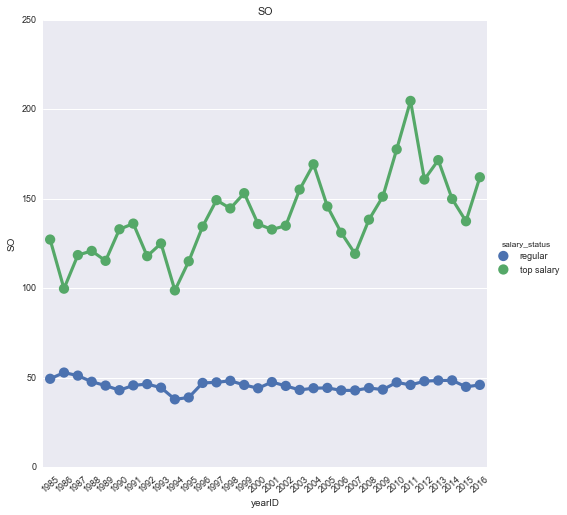

In [113]:
for measure in performances_pitching:
    f = sns.factorplot(x='yearID', y=measure, hue='salary_status', data=mean_pitching_stats_per_year, size=7)
    f.set_xticklabels(rotation=40)
    sns.plt.title(measure)

### Observations from the aboves graphs:
- ???


### Exploring fielding statistics

In [115]:
fielding_1985.head()

,playerID,yearID,stint,teamID,lgID,POS,G,GS,InnOuts,PO,A,E,DP,PB,WP,SB,CS,ZR
84257,aasedo01,1985,1,BAL,AL,P,54,0.0,264.0,8,10.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN
84258,abregjo01,1985,1,CHN,NL,P,6,5.0,72.0,1,6.0,1.0,0.0,NaN,NaN,NaN,NaN,NaN
84259,ackerji01,1985,1,TOR,AL,P,61,0.0,259.0,10,16.0,0.0,1.0,NaN,NaN,NaN,NaN,NaN
84260,adamsri02,1985,1,SFN,NL,2B,6,3.0,84.0,9,13.0,1.0,1.0,NaN,NaN,NaN,NaN,NaN
84261,adamsri02,1985,1,SFN,NL,3B,16,10.0,337.0,2,31.0,1.0,3.0,NaN,NaN,NaN,NaN,NaN


#### Which key performance measures should be explored?
- InnOuts: Time played in the field expressed as outs 
- PO: Putouts
- A: Assists
- E: Errors
- DP: Double Plays
- ZR: Zone Rating

In [116]:
fielding_1985['salary_status'] = fielding_1985['playerID'].apply(salary_status)

/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':


In [117]:
mean_fielding_stats_per_year = fielding_1985.groupby(['yearID', 'salary_status']).mean().reset_index()

In [118]:
performances_fielding = ['InnOuts', 'PO', 'A', 'E', 'DP', 'ZR']

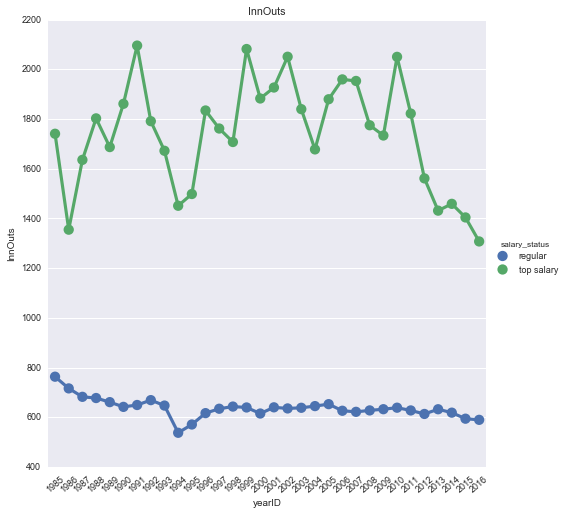

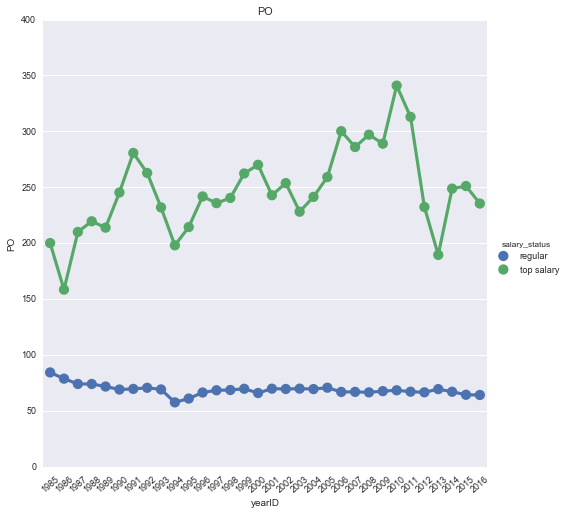

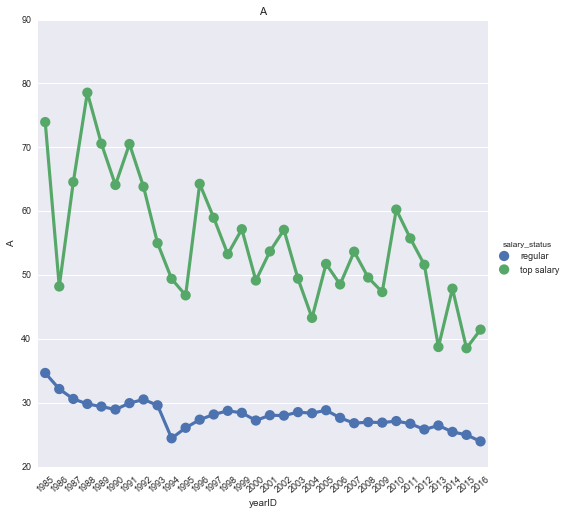

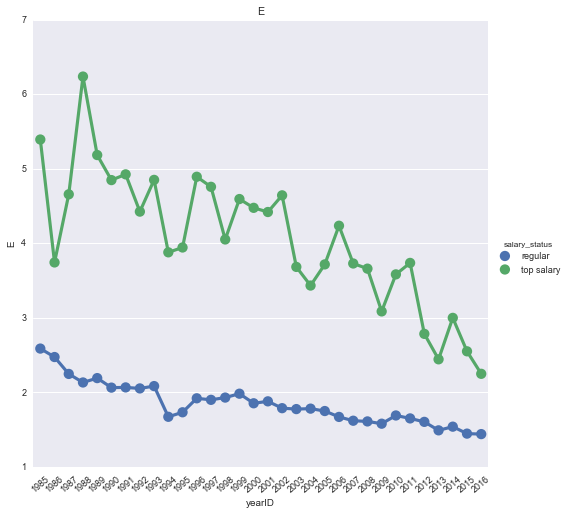

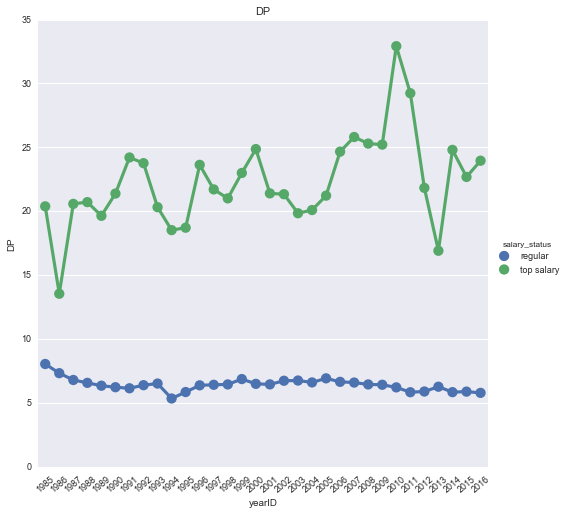

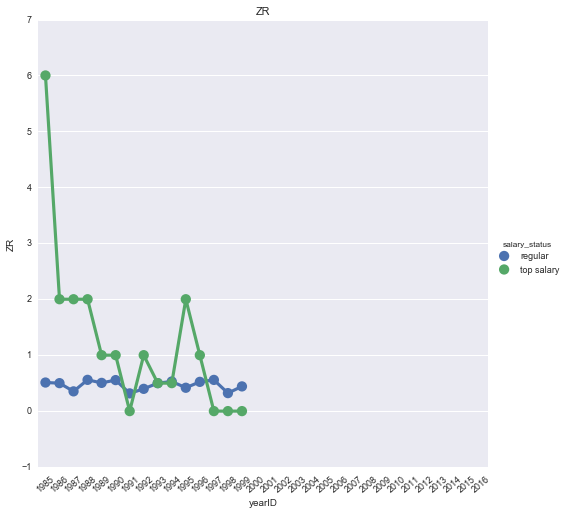

In [120]:
for measure in performances_fielding:
    f = sns.factorplot(x='yearID', y=measure, hue='salary_status', data=mean_fielding_stats_per_year, size=7)
    f.set_xticklabels(rotation=40)
    sns.plt.title(measure)

### Observations from the aboves graphs:
- ???

### Let's test if the difference in performances are significant for the different indicators for batting, pitching and fielding
- the null hypothesis is: mean performance on indicator X is equal for regular players and top salary
- the alternative hypothesis is that mean performance is different between the two indicators

In [86]:
from scipy import stats

In [133]:
print "Indicators for batting stats"
for indicator in indicators:
    print indicator
    print stats.ttest_ind((mean_battling_stats_per_year\
                [mean_battling_stats_per_year['salary_status']=='top salary'][indicator]),(mean_battling_stats_per_year\
                [mean_battling_stats_per_year['salary_status']=='regular'][indicator]))
print "\nIndicators for pitching stats"
for indicator in performances_pitching:
    print indicator
    print stats.ttest_ind((mean_pitching_stats_per_year\
                [mean_pitching_stats_per_year['salary_status']=='top salary'][indicator]),(mean_pitching_stats_per_year\
                [mean_pitching_stats_per_year['salary_status']=='regular'][indicator]))
print "\nIndicators for fielding stats"
for indicator in performances_fielding:
    print indicator
    print stats.ttest_ind((mean_fielding_stats_per_year\
                [mean_fielding_stats_per_year['salary_status']=='top salary'][indicator]),(mean_fielding_stats_per_year\
                [mean_fielding_stats_per_year['salary_status']=='regular'][indicator]))

Indicators for batting stats
HR
Ttest_indResult(statistic=20.629662396726584, pvalue=1.8500352790067924e-29)
RBI
Ttest_indResult(statistic=25.125211480187556, pvalue=3.3091683494186566e-34)
H
Ttest_indResult(statistic=29.277098441964817, pvalue=5.2222145365052791e-38)
R
Ttest_indResult(statistic=21.339104756664284, pvalue=2.9337624761117178e-30)
IBB
Ttest_indResult(statistic=21.540235951409837, pvalue=1.7554028250916583e-30)
2B
Ttest_indResult(statistic=27.82893842400895, pvalue=9.7427285978428348e-37)
3B
Ttest_indResult(statistic=7.5306573746339209, pvalue=2.5835407823321187e-10)
SO
Ttest_indResult(statistic=30.960651743418381, pvalue=2.0290212702284198e-39)
G
Ttest_indResult(statistic=24.425304961642986, pvalue=1.6282474865588253e-33)

Indicators for pitching stats
W
Ttest_indResult(statistic=28.406689672885882, pvalue=2.9854246338424532e-37)
L
Ttest_indResult(statistic=17.889130607041434, pvalue=3.635636960337844e-26)
G
Ttest_indResult(statistic=2.3911905604935231, pvalue=0.01984248

## What is the influence of college on players earnings?

In [57]:
collegePlaying_1985 = collegePlaying[collegePlaying['yearID']>=1985]

In [58]:
collegePlaying_1985['salary_status'] = collegePlaying_1985['playerID'].apply(salary_status)

/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':


In [59]:
collegePlaying_1985.head()

,playerID,schoolID,yearID,salary_status
0,aardsda01,pennst,2001,regular
1,aardsda01,rice,2002,regular
2,aardsda01,rice,2003,regular
3,abadan01,gamiddl,1992,regular
4,abadan01,gamiddl,1993,regular


In [60]:
collegePlaying_1985.groupby(['schoolID', 'salary_status'])['playerID'].count()

schoolID       salary_status
akron          regular            3
alabama        regular           51
albertsnid     regular            1
albevil        regular            2
alcalho        regular            2
alchatt        regular            4
alenter        regular            2
alfaulk        regular            4
alfscco        regular            1
aljeffd        regular           11
allegheny      regular            2
alnorth        regular            1
alsuscc        regular            4
alverniapa     regular            8
andersonsc     regular            4
arftsmi        regular            2
arizona        regular           80
arizonast      regular           97
               top salary         1
arkansas       regular           56
               top salary         1
arkansaslr     regular            3
arkansasst     regular            4
arktech        regular            2
armstratl      regular            3
arnorth        regular            1
ashland        regular            4

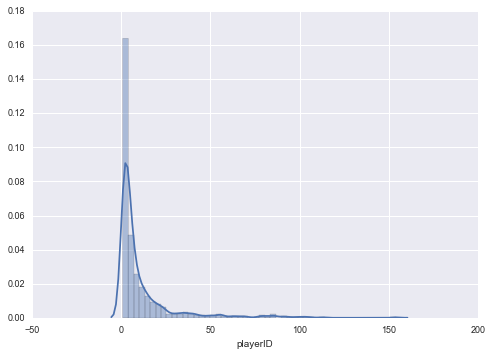

In [61]:
sns.distplot(collegePlaying_1985.groupby(['schoolID'])['playerID'].count())

Low number are the most common

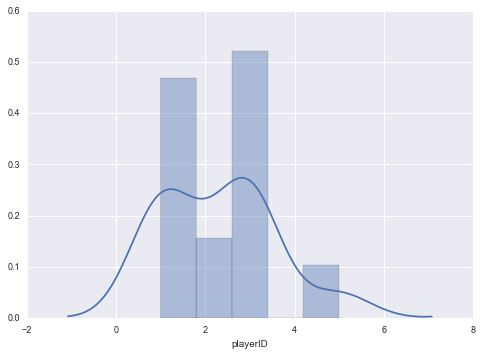

In [62]:
sns.distplot((collegePlaying_1985[collegePlaying_1985\
                                 ['salary_status']=='top salary']).groupby('schoolID')['playerID'].count(),
            bins=5)

It interesting to note that 3 is the most frequent number of players

Two colleges have 5 top salary players and they are with the highest number of regular players
stanford       
- regular          149
- top salary         5
               
gatech
- regular           86
- top salary         5

But out of the 105 top salaries on the period 1985-2016 10% come from these two colleges
out of 662 colleges in the sample 
- so college is an important variable

In [63]:
len(top_1pct_salaries_per_annum.playerID.unique()), len(collegePlaying_1985.schoolID.unique())


(105, 662)

Where did our outliers come from ?

In [64]:
outliers.playerID.unique()

array(['fostege01', 'yountro01', 'bonilbo01', 'fieldce01', 'sheffga01',
       'belleal01', 'brownke01', 'rodrial01', 'kershcl01'], dtype=object)

In [65]:
for player in outliers.playerID.unique():
    if player in collegePlaying_1985.playerID.unique():
        print collegePlaying_1985[collegePlaying_1985['playerID']==player]

       playerID schoolID  yearID salary_status
1001  belleal01      lsu    1985    top salary
1002  belleal01      lsu    1986    top salary
1003  belleal01      lsu    1987    top salary
       playerID schoolID  yearID salary_status
1862  brownke01   gatech    1985    top salary
1863  brownke01   gatech    1986    top salary


of the ouliers only two players attended college in the USA

## Looking into award players

In [66]:
awardPlayers_1985 = awardPlayers[awardPlayers['yearID']>=1985]

In [67]:
awardPlayers_1985.head()

,playerID,awardID,yearID,lgID,tie,notes
3760,brettge01,ALCS MVP,1985,AL,NaN,NaN
3761,hoytla01,All-Star Game MVP,1985,ML,NaN,NaN
3762,saberbr01,Babe Ruth Award,1985,AL,NaN,P
3763,saberbr01,Cy Young Award,1985,AL,NaN,NaN
3764,goodedw01,Cy Young Award,1985,NL,NaN,NaN


In [68]:
awardPlayers_1985.awardID.unique()

array(['ALCS MVP', 'All-Star Game MVP', 'Babe Ruth Award',
       'Cy Young Award', 'Gold Glove', 'Hutch Award',
       'Lou Gehrig Memorial Award', 'Most Valuable Player', 'NLCS MVP',
       'Pitching Triple Crown', 'Roberto Clemente Award',
       'Rolaids Relief Man Award', 'Rookie of the Year', 'Silver Slugger',
       'TSN All-Star', 'TSN Fireman of the Year',
       'TSN Major League Player of the Year', 'TSN Pitcher of the Year',
       'TSN Player of the Year', 'World Series MVP', 'Branch Rickey Award',
       'Hank Aaron Award', 'TSN Reliever of the Year',
       'Comeback Player of the Year', 'Triple Crown',
       'Outstanding DH Award', 'Reliever of the Year Award'], dtype=object)

In [69]:
awardPlayers_1985['salary_status'] = awardPlayers_1985['playerID'].apply(salary_status)

/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':


In [70]:
awardPlayers_1985.head()

,playerID,awardID,yearID,lgID,tie,notes,salary_status
3760,brettge01,ALCS MVP,1985,AL,NaN,NaN,top salary
3761,hoytla01,All-Star Game MVP,1985,ML,NaN,NaN,regular
3762,saberbr01,Babe Ruth Award,1985,AL,NaN,P,regular
3763,saberbr01,Cy Young Award,1985,AL,NaN,NaN,regular
3764,goodedw01,Cy Young Award,1985,NL,NaN,NaN,top salary


In [71]:
awardPlayers.groupby(['playerID']).count().sort_index(ascending=True)

,awardID,yearID,lgID,tie,notes
playerID,,,,,
aaronha01,16,16,16,0,12
abbotji01,2,2,2,0,1
abernte02,2,2,2,0,0
abreubo01,2,2,2,0,2
abreujo02,2,2,2,0,1
adamsba01,2,2,2,0,2
ageeto01,3,3,3,0,2
ainsmed01,1,1,1,0,1
akerja01,1,1,1,0,0
